In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pymongo
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [15]:
samples = exp.list_samples()
samples = [x for x in samples if 'hc' not in x]
samples = samples[0:13] + [samples[14]]

In [155]:
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method, parent):
    parent = hc.get_population_df(parent)
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    if manual_pop == 'lymphocytes':
        gating_performance['populations'].append('lymphocytes')
    else:
        gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [156]:
for x in samples:
    if x == 'sep37':
        continue
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
        
        auto_pop = f'{method}_lymphocytes'
        check_performance(hc, 'manual_lymphocytes', auto_pop, method, 'cells')
        
        auto_pop = f'{method}_liveCD3'
        check_performance(hc, 'manual_liveCD3', auto_pop, method, 'manual_lymphocytes')
        
        auto_pop = f'{method}_gdt'
        check_performance(hc, 'manual_gdt', auto_pop, method, 'manual_liveCD3')
        try:
            auto_pop = f'{method}_mait'
            check_performance(hc, 'manual_mait', auto_pop, method, 'manual_nongdt')
        except KeyError:
            check_performance(hc, 'manual_mait', 'hdbscan_maits', method, 'manual_nongdt')
        
        auto_pop = f'{method}_cd4'
        check_performance(hc, 'manual_cd4', auto_pop, method, 'manual_classic')

        auto_pop = f'{method}_cd8'
        check_performance(hc, 'manual_cd8', auto_pop, method, 'manual_classic')
        

Assessing performance for sep6
Assessing performance for sep13
Assessing performance for sep17
Assessing performance for sep19
Assessing performance for sep28
Assessing performance for sep29
Assessing performance for sep34
Assessing performance for sep38
Assessing performance for sep49
Assessing performance for sep50
Assessing performance for sep51
Assessing performance for sep67
Assessing performance for sep71


In [157]:
def rename_method(x):
    if x.split('_')[0] == 'gmm':
        return 'Gaussian Mixture Model'
    if x.split('_')[0] == 'dbscan':
        return 'DBSCAN'
    if x.split('_')[0] == 'hdbscan':
        return 'HDBSCAN'
    if x.split('_')[0] == 'dens2d':
        return 'Density threshold (2D)'
    return x
def rename_populations(x):
    if x == 'lymphocytes':
        return 'Lymphocytes'
    if x == 'liveCD3':
        return 'Live CD3+'
    if x == 'gdt':
        return 'γδ T cells'
    if x == 'mait':
        return 'MAITs'
    if x == 'cd4':
        return 'CD4'
    if x == 'cd8':
        return 'CD8'
    return x
results = pd.DataFrame(gating_performance)
results['method'] = results['method'].apply(rename_method)
results['population'] = results['population'].apply(rename_populations)

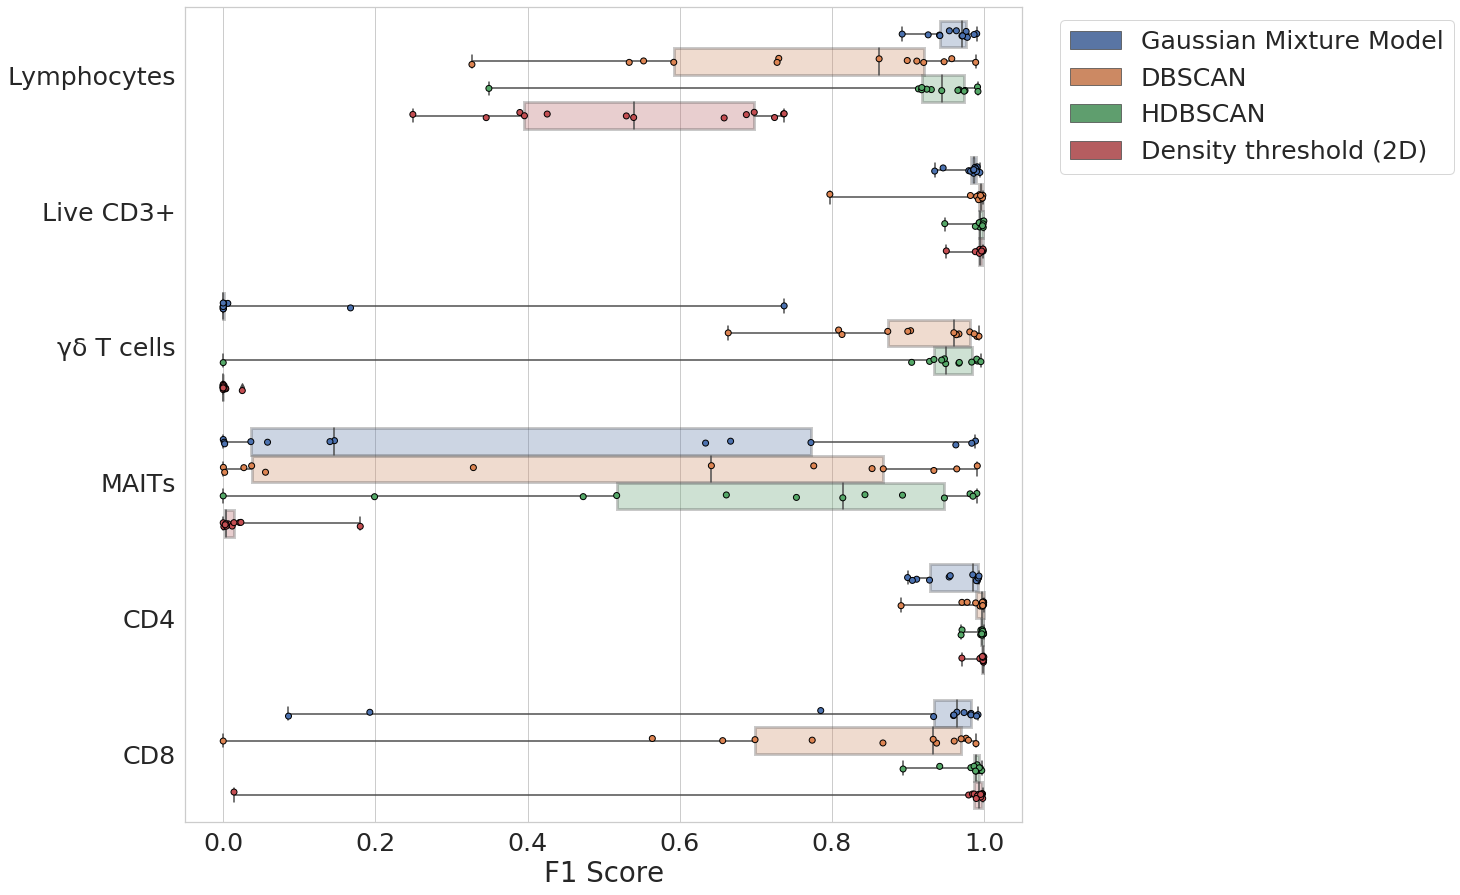

In [164]:
import seaborn as sns
sns.set(font_scale=2.3)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.boxplot(x="f1_score", y="population", data=results, whis=np.inf, hue='method',
                boxprops=dict(alpha=.3, linewidth=3))
ax = sns.stripplot(x="f1_score", y="population", data=results, hue='method', dodge=True, jitter=True,
                  s=6, edgecolor='black', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:4], labels=labels[:4], bbox_to_anchor=(1.03,1))
ax.set_xlabel('F1 Score')
ax.set_ylabel('')
ax.set_xlim(-0.05,1.05)
fig.savefig('Sepsis_Performance.jpg', res=300, bbox_inches='tight')

In [126]:
results[(results['method'] == 'Density threshold (2D)') & (results['population'] == 'Live CD3+')].sort_values('f1_score')

,sample_id,population,method,accuracy,f1_score,precision,recall,fpr
19,sep6,Live CD3+,Density threshold (2D),0.457770,0.0,0.0,0.0,0.002534
43,sep13,Live CD3+,Density threshold (2D),0.741777,0.0,0.0,0.0,0.013308
67,sep17,Live CD3+,Density threshold (2D),0.316877,0.0,0.0,0.0,0.135355
91,sep19,Live CD3+,Density threshold (2D),0.684633,0.0,0.0,0.0,0.007392
115,sep28,Live CD3+,Density threshold (2D),0.504435,0.0,0.0,0.0,0.012703
139,sep29,Live CD3+,Density threshold (2D),0.297510,0.0,0.0,0.0,0.140459
163,sep34,Live CD3+,Density threshold (2D),0.393608,0.0,0.0,0.0,0.010850
187,sep37,Live CD3+,Density threshold (2D),0.699141,0.0,0.0,0.0,0.014128
211,sep38,Live CD3+,Density threshold (2D),0.387386,0.0,0.0,0.0,0.187729
235,sep49,Live CD3+,Density threshold (2D),0.327203,0.0,0.0,0.0,0.045574


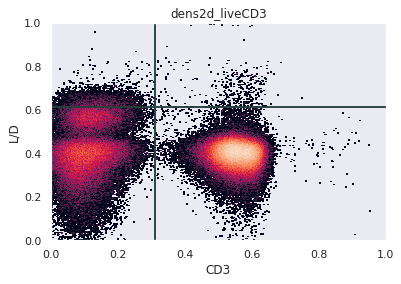

In [139]:
sep = Gating(exp, 'sep49')
sns.set(font_scale=1)
sep.plotting.plot_gate('dens2d_liveCD3')

In [123]:
sep.gates.pop('hdbscan_mait')

<Gate: Gate object>

In [124]:
sep.populations.pop('hdbscan_mait')
sep.populations.pop('hdbscan_classic')

Node('/root/cells/manual_lymphocytes/manual_liveCD3/manual_nongdt/hdbscan_classic', geom={'cords': {'x': [0.6185315146238127, 0.5961452406274149, 0.43571003063100794, 0.38463469986689197, 0.3524223231593537, 0.34086236580884793, 0.3174862270097423, 0.1152114586677821, 0.0768868255071084, 0.06971546988481336, 0.031078897911286263, 0.257051977458239, 0.2579740413280076, 0.26000786099976764, 0.27913933841660316, 0.33558786764636117, 0.35666150537436875, 0.391351717988187, 0.44492804602406993, 0.4484342138655891, 0.5122222390522873, 0.5133805618989129, 0.5312877449694747, 0.5348656747352327, 0.5639451670745382, 0.6185315146238127], 'y': [0.4056233998422222, 0.4909905809335602, 0.6275466669378164, 0.6476662923052504, 0.6495484156544524, 0.6488665961483912, 0.6446535930025782, 0.5813266272077725, 0.56492939437651, 0.554513126993725, 0.4270607394062637, -0.10115928916866962, -0.10329899742311194, -0.10589556791128274, -0.12469730297420512, -0.14881126118911026, -0.15577796511076025, -0.165192

Error: gate with name manual_mait already exists.


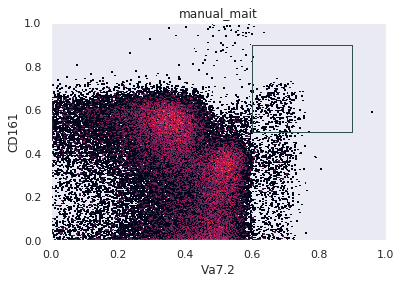

In [112]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_mait', definition='+')
child_populations.add_population('manual_classic', definition='-')

gate_definition = dict(x='Va7.2', y='CD161', x_min=0.6, x_max=0.9, y_min=0.5, y_max=0.9)
sep.create_gate(gate_name='manual_mait', parent='manual_nongdt', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)
sep.apply('manual_mait')

In [140]:
def calc_sample_frac(sep, parent):
    n = sep.get_population_df(parent).shape[0]
    frac = 0.2
    if n < 40000:
        return 0.99
    else:
        for x in [0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.12, 0.1, 0.08, 0.05, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0005]:
            if n*x < 40000:
                return x

parent = 'manual_nongdt'
frac = calc_sample_frac(sep, parent)
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_maits', target=(0.8, 0.8), weight=2)
child_populations.add_population('hdbscan_classic', target=(0.3, 0.3), weight=1)
gate_definition = dict(x='Va7.2', y='CD161', min_pop_size=10, frac=frac, downsample_method='density')
sep.create_gate(gate_name='hdbscan_maits', parent=parent, class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
sep.apply('hdbscan_maits')
#sep.save(overwrite=True)

Error: gate with name hdbscan_maits already exists.
Error: population hdbscan_maits already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again


In [113]:
sep.save(overwrite=True)

Saved successfully!


True

Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Saved successfully!


True

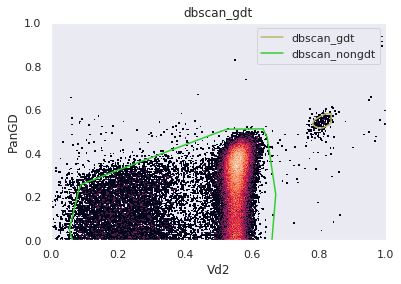

In [90]:
parent = 'manual_liveCD3'
frac = calc_sample_frac(sep, parent)
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=(0.8, 0.6), weight=1)
child_populations.add_population('dbscan_nongdt', target=(0.2, 0.2), weight=1)
gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=5, distance_nn=0.01, frac=frac, downsample_method='density')
sep.create_gate(gate_name='dbscan_gdt', parent=parent, class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)
sep.apply('dbscan_gdt')
sep.save(overwrite=True)

In [85]:
sep.save(overwrite=True)

Saved successfully!


True

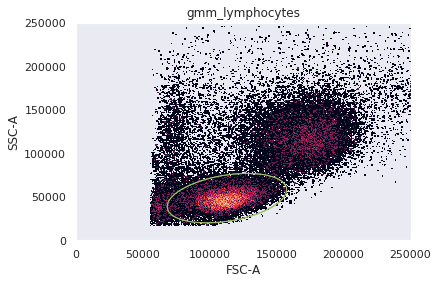

In [45]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(110000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99, transform_x=None, transform_y=None)
sep.create_gate(gate_name='gmm_lymphocytes', parent=parent, class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)
sep.apply('gmm_lymphocytes')

In [46]:
sep.save(overwrite=True)

Saved successfully!


True

In [134]:
for x in samples:
    if x == 'sep37':
        continue
    sep = Gating(exp, x)
    if 'dens2d_liveCD3' in sep.populations.keys():
        sep.populations.pop('dens2d_liveCD3')
        sep.populations.pop('dens2d_dead')
        sep.gates.pop('dens2d_liveCD3')
    parent='manual_lymphocytes'
    frac = calc_sample_frac(sep, parent)
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_liveCD3', definition='+-')
    child_populations.add_population('dens2d_dead', definition=['++', '--', '-+'])
    gate_definition = dict(x='CD3', y='L/D', kde_bw=0.1, frac=frac)
    sep.create_gate(gate_name='dens2d_liveCD3', parent='manual_lymphocytes', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dens2d_liveCD3', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
